In [2]:
def data_preprocessor(date_element):
    return "-".join(date_element.split('-')[:2])
data_preprocessor("2018-02-21")

'2018-02'

In [1]:

import quandl 
import pandas as pd 
SO  = pd.read_csv("currency_daily_BTC_CNY.csv").iloc[:,[0,5,6,7,8]][:400]
print(type(SO))
SO = SO.iloc[::-1]
print(type(SO))
SO = SO.reset_index(drop=True)
print(type(SO))
# SO["timestamp"] = SO["timestamp"].apply(data_preprocessor)
SO.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,timestamp,open (USD),high (USD),low (USD),close (USD)
0,2019-10-13,8301.98,8451.37,8160.00,8275.01
1,2019-10-14,8275.24,8388.85,8203.00,8348.20
2,2019-10-15,8346.86,8403.00,8090.00,8159.29
3,2019-10-16,8159.30,8181.16,7917.00,7991.74
4,2019-10-17,7995.02,8124.92,7929.03,8070.58


In [3]:
SO.shape

(400, 5)

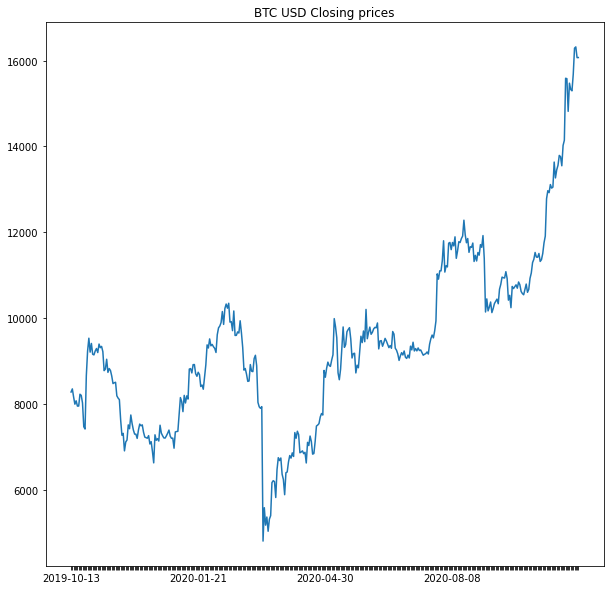

In [4]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=[10,10])


# SO["close (USD)"].plot(grid=True)
plt.plot( SO["timestamp"],SO["close (USD)"])
plt.title("BTC USD Closing prices")

every_nth = 100
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if (n%every_nth != 0):
        label.set_visible(False)

plt.show()

In [5]:
import numpy as np

short_window = 5
long_window = 40

signals = pd.DataFrame(SO.index)
signals['signal'] = 0.0

#EMA of short window
signals['short_mavg'] = SO['close (USD)'].ewm(span = short_window, adjust = False).mean()

#EMA of long window
signals['long_mavg'] = SO['close (USD)'].ewm(span = long_window, adjust = False).mean()

#Create signals
signals['signal'][short_window:] = np.where(signals["short_mavg"][short_window:] > signals["long_mavg"][short_window:], 1.0, 0.0)

#generate trading orders 
signals["positions"] = signals["signal"].diff()


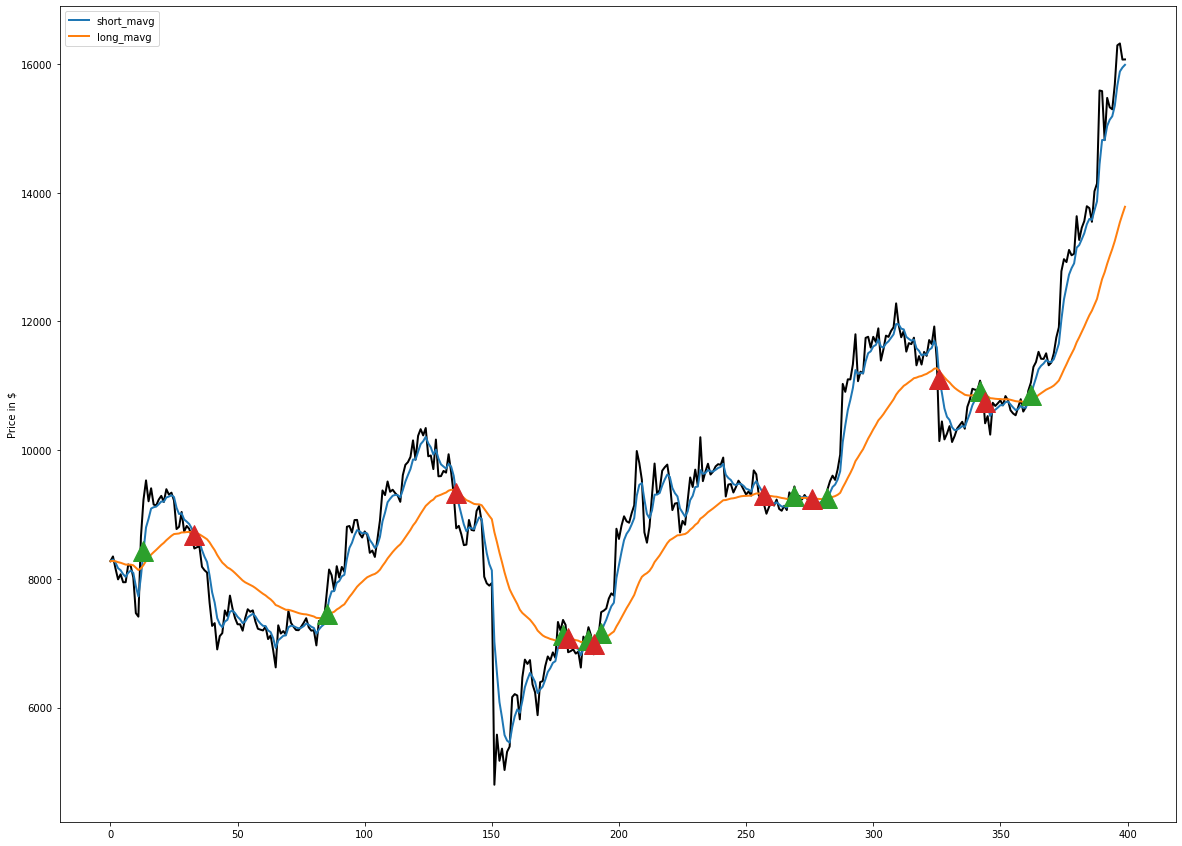

In [6]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(111, ylabel="Price in $")

SO["close (USD)"].plot(ax=ax1, color='black', lw = 2.)

signals[["short_mavg", "long_mavg"]].plot(ax=ax1, lw=2.)

#Plot the buy signals
ax1.plot(signals.loc[signals["positions"] == 1.0].index, signals.short_mavg[signals.positions == 1.0], '^', markersize=20)

#Plot the sell signals
ax1.plot(signals.loc[signals["positions"] == -1.0].index, signals.short_mavg[signals.positions == -1.0], '^', markersize=20)

In [7]:
initial_capital = float(10000)

positions = pd.DataFrame(index=signals.index).fillna(0.0)

positions["Position in HKD"] = 1*signals['signal']

portfolio = positions.multiply(SO["close (USD)"], axis=0)

poss_diff = positions.diff()

portfolio["holdings"] = (positions.multiply(SO["close (USD)"], axis=0)).sum(axis=1)

portfolio["cash"] = initial_capital - (poss_diff.multiply(SO["close (USD)"], axis=0)).sum(axis=1).cumsum()

portfolio["total"] = portfolio["cash"] + portfolio["holdings"]

portfolio["returns"] = portfolio["total"].pct_change()

del portfolio["Position in HKD"]

print(portfolio.tail())

     holdings    cash     total   returns
395  15684.24 -177.01  15507.23  0.025597
396  16291.86 -177.01  16114.85  0.039183
397  16320.70 -177.01  16143.69  0.001790
398  16070.45 -177.01  15893.44 -0.015501
399  16072.55 -177.01  15895.54  0.000132


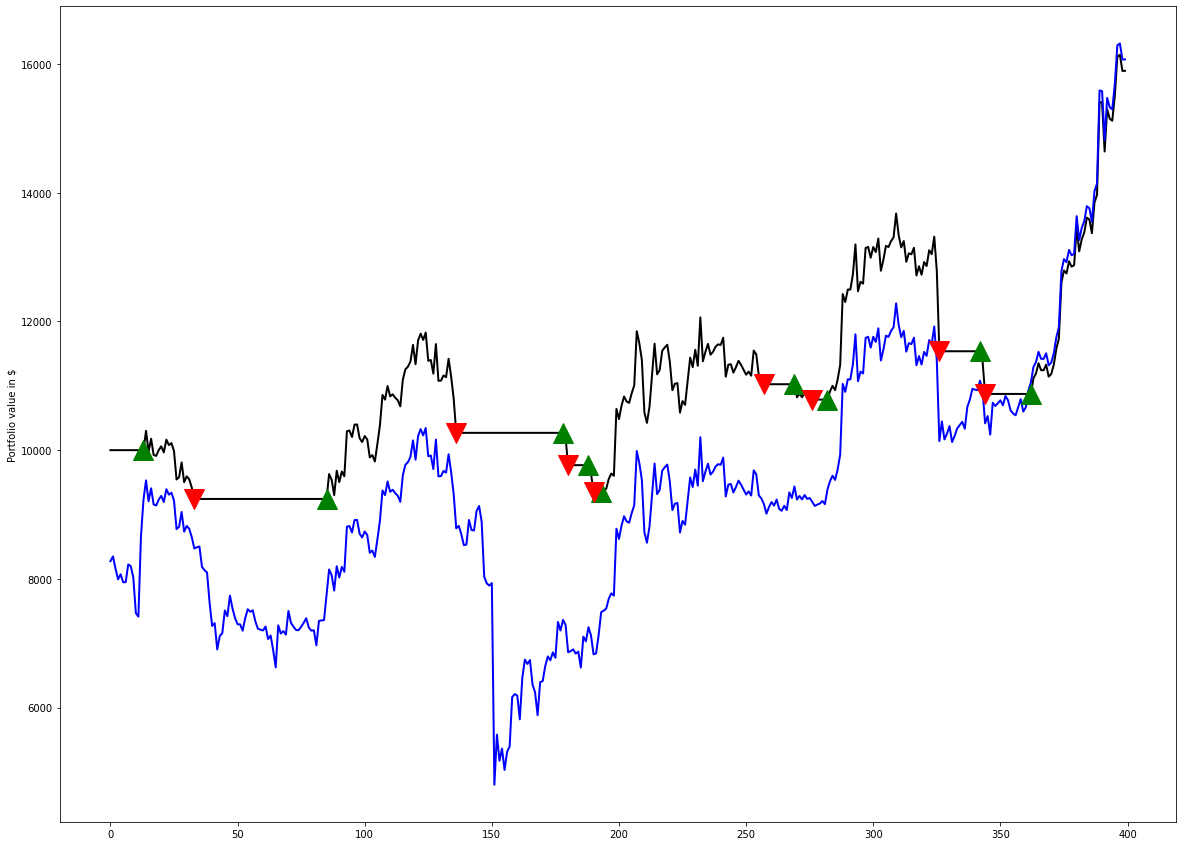

In [8]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(111, ylabel="Portfolio value in $")

# ax2 = fig.add_subplot(111, ylabel="Returns $")
# plot equit portfolio in $
portfolio["total"].plot(ax=ax1, lw=2., color='black')

#btc price
SO["close (USD)"].plot(ax=ax1, color='blue', lw = 2.)


ax1.plot(portfolio.loc[signals.positions==1.0].index,portfolio.total[signals.positions ==1.0], '^', markersize=20, color='g')

ax1.plot(portfolio.loc[signals.positions==-1.0].index,portfolio.total[signals.positions ==-1.0], 'v', markersize=20, color='r')


In [9]:
#total portfolio value
print("Portfolio value as of Nov 2020 after investing 10k in 2018")
print(portfolio['total'].tail(1))

print("Absolute return as of May 2018")
print(((portfolio['total'].tail(1)/float(10000)) -float(1))*100)


Portfolio value as of Nov 2020 after investing 10k in 2018
399    15895.54
Name: total, dtype: float64
Absolute return as of May 2018
399    58.9554
Name: total, dtype: float64


In [46]:
import pandas as pd
from ta.utils import dropna
from ta.trend import SMAIndicator

coinData = pd.DataFrame(data, columns=['MarketCAP','Open','High','Low','Close'])

smaInd = SMAIndicator(coinData["Close"], 3)

print(smaInd.sma_indicator())





0              NaN
1              NaN
2     15191.730000
3     15356.120000
4     15479.080000
5     15488.660000
6     15451.606667
7     15439.150000
8     15331.070000
9     15297.910000
10    15234.236667
11    15290.816667
12    15305.043333
13    15318.186667
14    15301.996667
15    15293.026667
16    15311.316667
17    15353.716667
18    15375.970000
19    15425.903333
20    15496.980000
21    15642.810000
22    15721.003333
23    15726.693333
24    15722.770000
25    15727.006667
26    15834.086667
27    15932.120000
28    16087.113333
29    16245.333333
30    16312.853333
31    16275.216667
32    16201.013333
33    16189.890000
34    16250.520000
35    16245.826667
36    16219.393333
37    16065.736667
38    16011.310000
39    15921.480000
40    15987.136667
41    15980.040000
42    15990.930000
Name: sma_3, dtype: float64


In [19]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import plotly.graph_objects as go
import json

url = 'https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=7'


try:
  response = session.get(url)
  data = json.loads(response.text)
  coinData = pd.DataFrame(data, columns=['MarketCAP','Open','High','Low','Close'])
  print(data)
  fig = go.Figure(data=go.Ohlc(x=df['Date'],
                    open=df['AAPL.Open'],
                    high=df['AAPL.High'],
                    low=df['AAPL.Low'],
                    close=df['AAPL.Close']))
  
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


[[1604822400000, 15032.68, 15032.68, 15004.09, 15004.09], [1604836800000, 14946.22, 15137.89, 14946.22, 15137.89], [1604851200000, 15148.12, 15433.21, 15148.12, 15433.21], [1604865600000, 15315.02, 15561.6, 15315.02, 15497.26], [1604880000000, 15404.77, 15506.77, 15316.21, 15506.77], [1604894400000, 15467.51, 15563.16, 15461.95, 15461.95], [1604908800000, 15445.25, 15449.8, 15366.78, 15386.1], [1604923200000, 15299.29, 15469.4, 15299.29, 15469.4], [1604937600000, 15783.91, 15783.91, 15137.71, 15137.71], [1604952000000, 15016.17, 15286.62, 15016.17, 15286.62], [1604966400000, 15387.82, 15387.82, 15278.38, 15278.38], [1604980800000, 15283.59, 15388.12, 15282.04, 15307.45], [1604995200000, 15349.6, 15391.56, 15329.3, 15329.3], [1605009600000, 15291.47, 15358.15, 15291.47, 15317.81], [1605024000000, 15264.18, 15312.52, 15258.88, 15258.88], [1605038400000, 15217.7, 15302.39, 15217.7, 15302.39], [1605052800000, 15316.44, 15372.68, 15316.44, 15372.68], [1605067200000, 15290.06, 15447.44, 1529